In [38]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
import cv2
import sklearn
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from sklearn.utils.class_weight import compute_class_weight
from keras.models import model_from_json
from keras.models import load_model
from tensorflow.keras.preprocessing import image


In [4]:
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"

In [5]:
img_size = 48

train_datagen = ImageDataGenerator(width_shift_range = 0.1,height_shift_range = 0.1,
                                    horizontal_flip = True,rescale = 1./255,
                                    validation_split = 0.2)

validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)


In [6]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training")

validation_generator = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation")

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [7]:
class_indices = train_generator.class_indices  # Mapping of class names to indices
class_labels = list(class_indices.values())   # Class indices as a list
class_names = list(class_indices.keys())      # Class names as a list

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),  # Unique class labels
    y=train_generator.classes                   # Class labels from training data
)

# Convert to a dictionary (Keras expects a dictionary)
class_weights_dict = {class_label: weight for class_label, weight in zip(class_labels, class_weights)}
print("Class Weights:", class_weights_dict)

class_weights_dict[1] = min(class_weights_dict[1], 5.0)  # Cap extreme weights

for key in class_weights_dict:
    class_weights_dict[key] = max(0.5, min(class_weights_dict[key], 5.0))



Class Weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


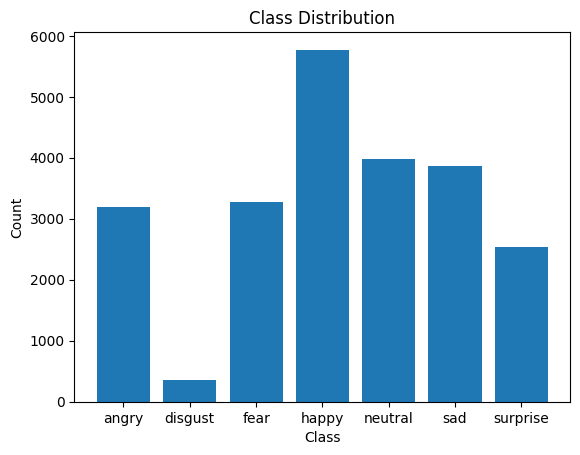

In [8]:
class_counts = np.bincount(train_generator.classes)

plt.bar(range(len(class_counts)), class_counts, tick_label=class_names)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [12]:
model = tf.keras.Sequential([

        # input layer
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,1)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 1st hidden dense layer
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 2nd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 3rd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # Flatten layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        # output layer
        tf.keras.layers.Dense(7, activation='softmax')
    ])

In [13]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 23, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,841,543 (14.65 MB)

 Trainable params: 3,837,575 (14.64 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [14]:
epochs = 150
batch_size = 64

In [15]:
= model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator,class_weight =class_weights_dict)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734023386.476445     103 service.cc:145] XLA service 0x7931c80019f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734023386.476505     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/359 ━━━━━━━━━━━━━━━━━━━━ 1:52:28 19s/step - accuracy: 0.1719 - loss: 9.9111

I0000 00:00:1734023399.164661     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 135s 324ms/step - accuracy: 0.1526 - loss: 9.7957 - val_accuracy: 0.0524 - val_loss: 9.3001
Epoch 2/150
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.1653 - loss: 9.5826 - val_accuracy: 0.1774 - val_loss: 9.0991
Epoch 3/150
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.1716 - loss: 9.4605 - val_accuracy: 0.2172 - val_loss: 9.0003
Epoch 4/150
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.1730 - loss: 9.3587 - val_accuracy: 0.2200 - val_loss: 8.9261
Epoch 5/150
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.1808 - loss: 9.2442 - val_accuracy: 0.2221 - val_loss: 8.8720
Epoch 6/150
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.1822 - loss: 9.1413 - val_accuracy: 0.2486 - val_loss: 8.7809
Epoch 7/150
359/359 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.1843 - loss: 9.0608 - val_accuracy: 0.2228 - val_loss: 8.7411
Epoch 8/150
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.1903 - loss: 8.9696 - va

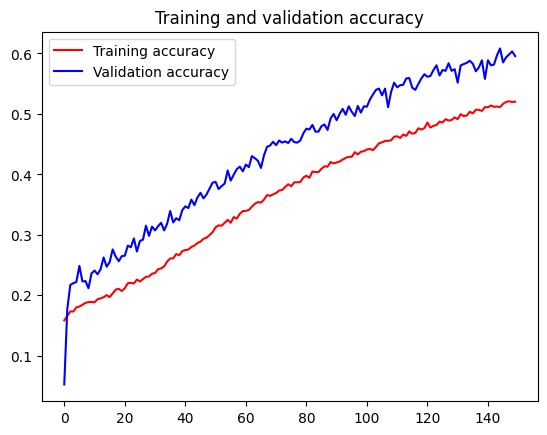

<Figure size 640x480 with 0 Axes>

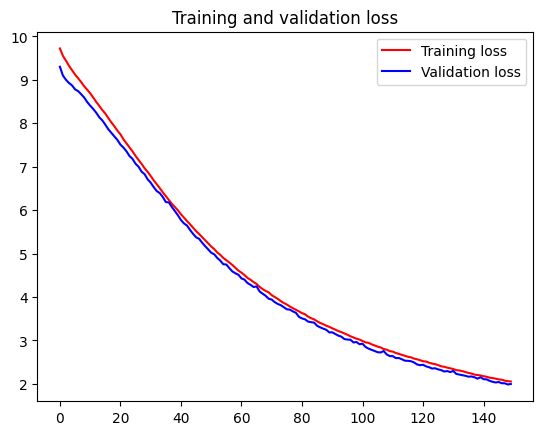

In [16]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [17]:
model.save('model_fer2013.h5')

In [18]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.5708 - loss: 1.9974
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6058 - loss: 1.9937
final train accuracy = 57.43 , validation accuracy = 59.57


(48, 48)


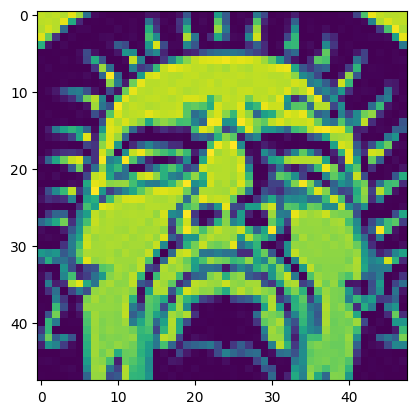

In [19]:
img = image.load_img("/kaggle/input/fer2013/test/fear/PrivateTest_1161501.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [20]:
= {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [21]:
img = np.expand_dims(img,axis = 0) 
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [22]:
img_index = result.index(max(result))
print(Classes[img_index])
plt.show()

Fear


In [23]:
model.save_weights('model_weights.weights.h5')

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


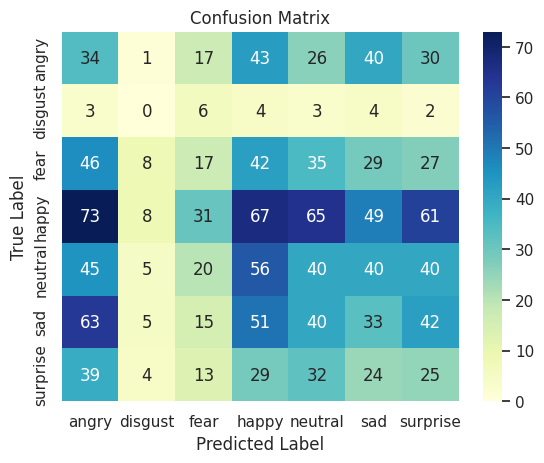

In [24]:
# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred,axis=1)

y_true = validation_generator.classes

f1 = f1_score(y_true,y_pred_classes,average = 'weighted')
print(f"F1-Score (weighted): {f1:.2f}")

class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
F1-Score (weighted): 0.17
              precision    recall  f1-score   support

       angry       0.13      0.20      0.15       191
     disgust       0.00      0.00      0.00        22
        fear       0.16      0.09      0.12       204
       happy       0.23      0.19      0.20       354
     neutral       0.20      0.19      0.19       246
         sad       0.20      0.17      0.18       249
    surprise       0.09      0.13      0.11       166

    accuracy                           0.16      1432
   macro avg       0.14      0.14      0.14      1432
weighted avg       0.17      0.16      0.17      1432



In [29]:
# Save model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save trained model weights to an H5 file
model.save_weights("model.weights.h5")

In [33]:
json_file = open('model.json','r')
loaded_json_model = json_file.read()
json_file.close()
model = model_from_json(loaded_json_model)